Let's look step-by-step how we can generate these polygon backgrounds.

# Generating points

In [1]:
import numpy as np
from random import random
from math import floor
import matplotlib.pyplot as plt

In [2]:
# Variables
graphWidth = 1920
graphHeight = 1080
bleedX = 200
bleedY = 200
cellSize = 190
variance = 50
randomFunction = random
color_steps = 20

First let's generate a scattering of points on a 2d graph. 

We don't want to just have a grid that is defined at each integer point and we want to have the points to be somewhat far away from each other.

$$ X = \lfloor{i + h_c + (R * v*2 - v)}\rfloor $$

Where $h_c$ = 

In [3]:
def gen_grid(w, h, b_x, b_y, cell_size, variance, rand_fn):
    """ Calculates random 2d dot array

    Keyword Arguments:
    w         -- width of grid
    h         -- height of grid
    b_x       -- bleed in the x dimmension
    b_y       -- bleed in the y dimmension
    cell_size -- size of each triangle cell
    variance  -- variance in each placement
    rand_fn   -- function to generate random numbers
    """

    w = w + b_x
    h = h + b_y
    half_cell = cell_size * 0.5

    points = []
    cell_size = int(cell_size)
    for i in range(-b_x, w, cell_size):
        for j in range(-b_y, h, cell_size):
            x = floor((i + half_cell) + (rand_fn() * variance*2 - variance))
            y = floor((j + half_cell) + (rand_fn() * variance*2 - variance))
            points.append([int(x), int(y)])

    return np.array(points)

In [4]:
samplePoints = gen_grid(graphWidth, graphHeight, bleedX, bleedY, cellSize, variance, randomFunction)

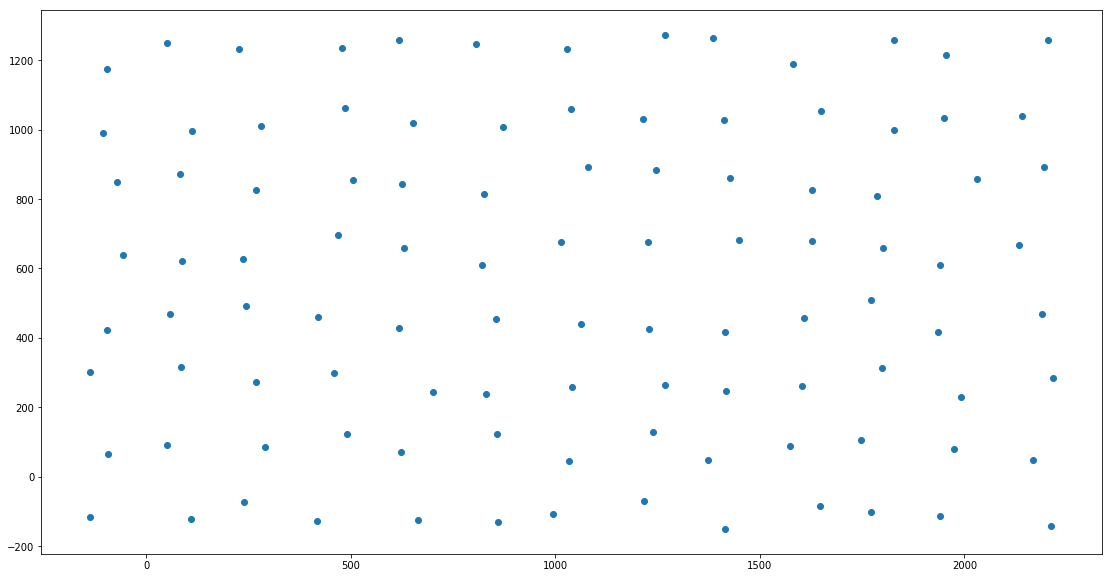

In [5]:
fig = plt.figure(figsize=(19,10))
plt.scatter(samplePoints[:,0], samplePoints[:,1])

Nice! Now we want to draw triangles between these points. There are a couple of aproaches that we could choose from, but luckily for us, we want to take advantage of already existing methods.

We'll take advantage of __Delaunay triangulation__ to create our triangles from our random point grid. [The explanation of how this works is out of scope for this notebook, but you can read more about the specific technique here](https://www.wikiwand.com/en/Delaunay_triangulation)

In [40]:
from scipy.spatial import Delaunay
from skimage.draw import polygon

In [41]:
tri = Delaunay(samplePoints).simplices

The simplices are the "indices of the points forming the simplices in the triangulation" which will make our lives easy. Let's look at one of these items

In [43]:
tri[0]

array([103, 101,  98], dtype=int32)

So these three numbers act as the indexes of the `samplePoints` list which will form our triangle. So if we index that array accordingly, we can draw our triangle from those points. Let's see what that looks like

In [44]:
from matplotlib.patches import Polygon

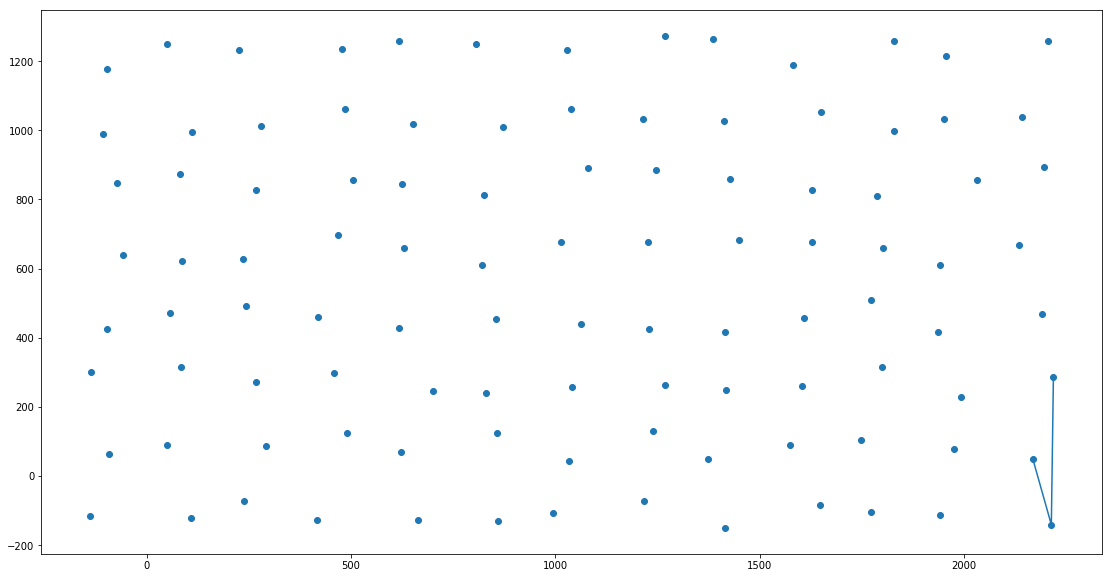

In [45]:
fig = plt.figure(figsize=(19,10))

point = samplePoints[tri][5]
plt.plot(point[:, 0],point[:, 1])

plt.scatter(samplePoints[:,0], samplePoints[:,1])

Not bad, looks like those are, infact, three points making a triangle, let's look at a couple more

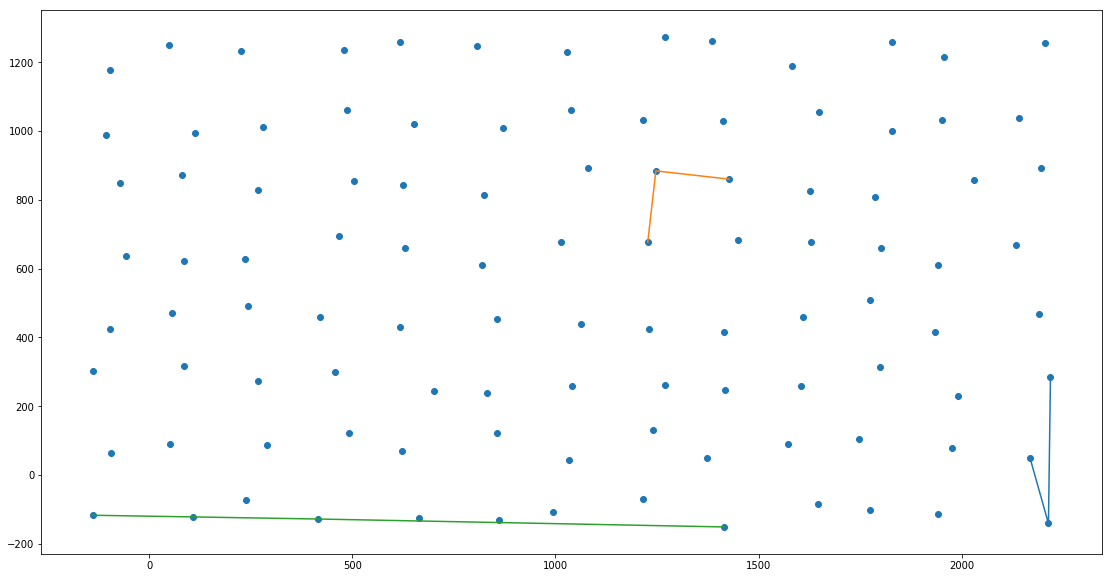

In [46]:
fig = plt.figure(figsize=(19,10))

point = samplePoints[tri][5]
plt.plot(point[:, 0],point[:, 1])

point = samplePoints[tri][25]
plt.plot(point[:, 0],point[:, 1])

point = samplePoints[tri][55]
plt.plot(point[:, 0],point[:, 1])

plt.scatter(samplePoints[:,0], samplePoints[:,1])

Ok, so we can see that it does pick up three different points and draws a triangle. Let's see what the entire dataset looks like.

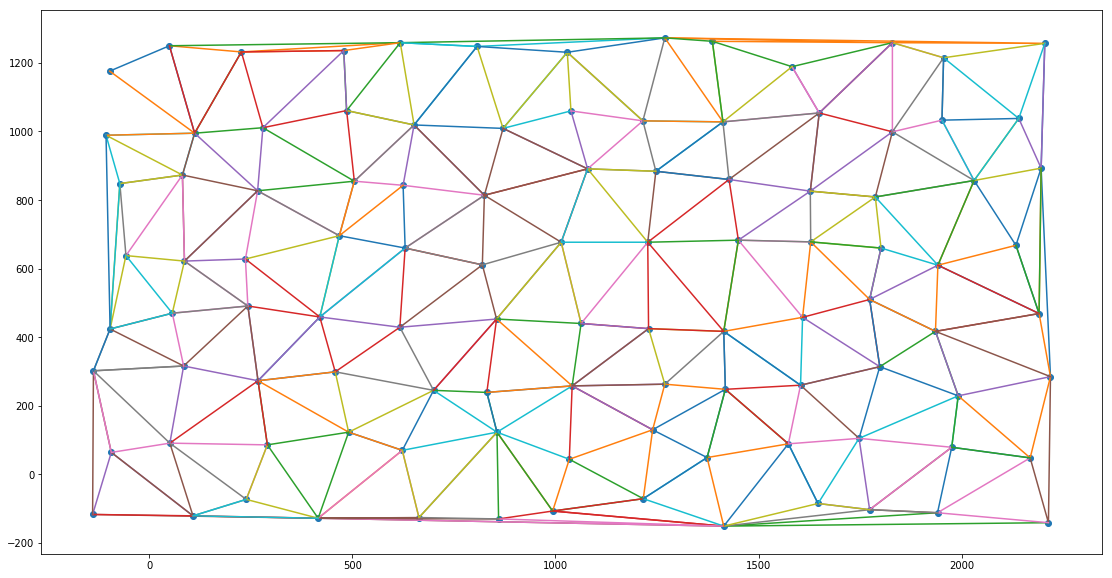

In [12]:
fig = plt.figure(figsize=(19,10))
for point in samplePoints[tri]:
        #print(tri)
        c = point[:, 0]
        r = point[:, 1]
        plt.plot(c,r)        
plt.scatter(samplePoints[:,0], samplePoints[:,1])

Not bad, but because we gave it three points, it doesn't close the triangle which means it's missing some of the edges. 

Let's use the `Polygon` class to make filled areas.

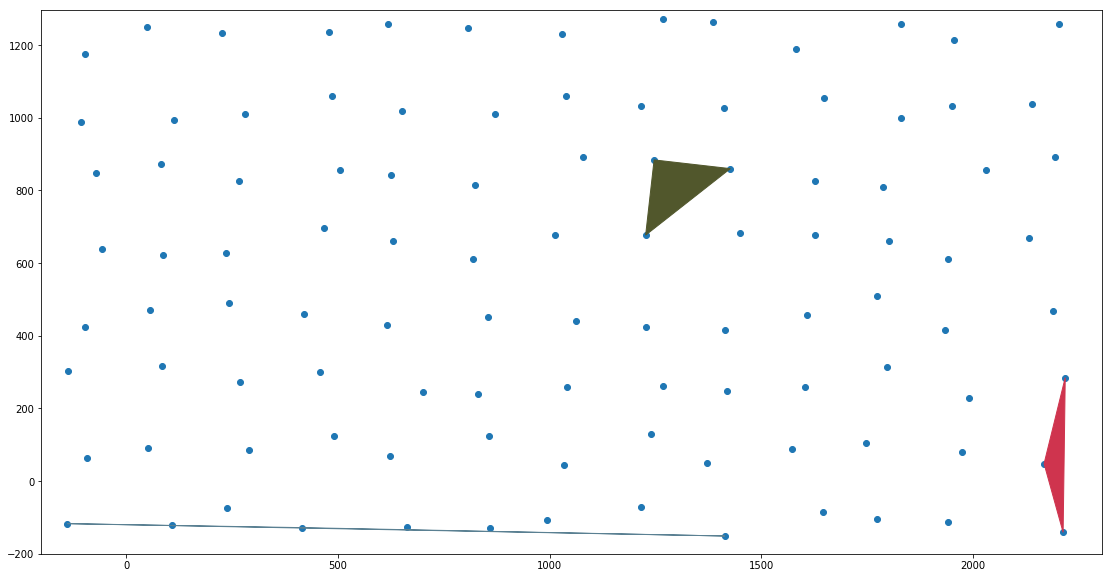

In [47]:
fig = plt.figure(figsize=(19,10))
ax = plt.gca()        

point = samplePoints[tri][5]
p = Polygon(point, closed=True, color=[random(),random(),random(),1])
ax.add_patch(p)

point = samplePoints[tri][25]
p = Polygon(point, closed=True, color=[random(),random(),random(),1])
ax.add_patch(p)

point = samplePoints[tri][55]
p = Polygon(point, closed=True, color=[random(),random(),random(),1])
ax.add_patch(p)

ax.set_xlim(-200,graphWidth*1.2)
ax.set_ylim(-200,graphHeight*1.2)
plt.scatter(samplePoints[:,0], samplePoints[:,1])

That's better, let's do the entire dataset!

(-200, 1296.0)

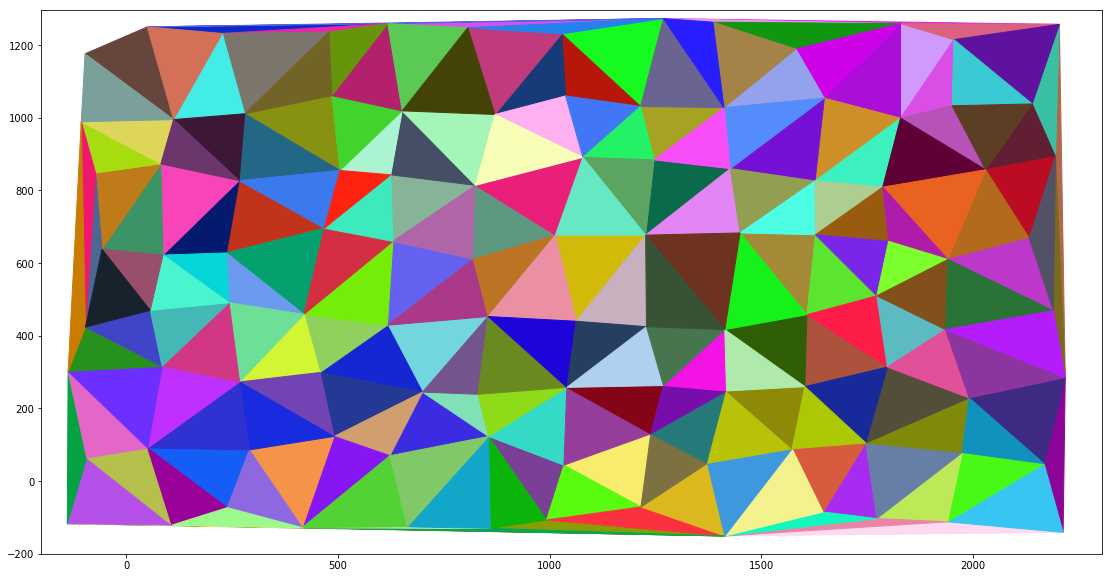

In [14]:
fig = plt.figure(figsize=(19,10))

ax = plt.gca()

for point in samplePoints[tri]:
        p = Polygon(point, closed=True, color=[random(),random(),random(),1])
        ax.add_patch(p)
        
#plt.scatter(samplePoints[:,0], samplePoints[:,1])
ax.set_xlim(-200,graphWidth*1.2)
ax.set_ylim(-200,graphHeight*1.2)

Wow, we've got some abstract art going on with these random colors. Très chic. But we want something with a little bit more structures in the colors. Let's use the placement of each polygon patch to define the colors it will use.

In [48]:
def centerTriangle(tri):
    """ Calculates (X,Y) center of a triangle.

    Keyword Arguments:
    tri -- a 2x3 array where each element is a coord of the triangle
    """
    return ((tri[0][0] + tri[1][0] + tri[2][0]) / 3,
            (tri[0][1] + tri[1][1] + tri[2][1]) / 3
           )

In [49]:
def remap(OldValue, OldMin, OldMax, NewMin, NewMax):
    """ Preforms a linear remap of OldValue from an OldRange to a New Range
    Keyword Arguments:
    OldValue -- Value to remap
    OldMin   -- Minimum value of old range
    OldMax   -- Maximum value of old range
    NewMin   -- Minimum value of new range
    NewMax   -- Maximum value of new range
    """
    return (((OldValue - OldMin) * (NewMax - NewMin)) /
            (OldMax - OldMin)) + NewMin

def normalizeCoordinate(oldValue, bleedValue, maxValue):
    return max(0, remap(oldValue, -bleedValue, maxValue + bleedValue, 0.0, 1.0))

(-200, 1296.0)

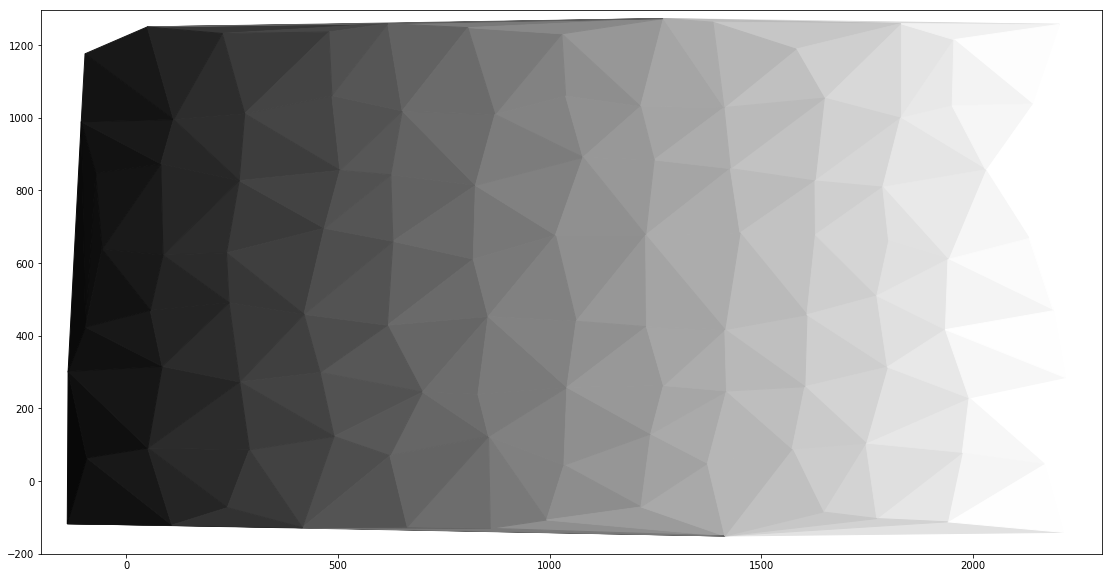

In [17]:
fig = plt.figure(figsize=(19,10))

ax = plt.gca()

for point in samplePoints[tri]:
    centers = centerTriangle(point)
    percentageX = min(normalizeCoordinate(centers[0],bleedX,graphWidth),1)
    p = Polygon(point, closed=True, color=[percentageX,percentageX,percentageX,1])
    ax.add_patch(p)
        
#plt.scatter(samplePoints[:,0], samplePoints[:,1])
ax.set_xlim(-200,graphWidth*1.2)
ax.set_ylim(-200,graphHeight*1.2)

Now we have a very nice gradient from one side to another. Giving it more form and structure, but we're kinda abusing the emergent properties of grayscale and position. We're also much interested in colorschemes, so let's add more features that can help us control the colors.

In [50]:
from colour import Color

In [59]:
color_steps = 25

first_c = Color("#febf01")
second_c = Color("#ff02f6")

In [60]:
def calculate_gradient(startcolor, endcolor, transition_steps):
    """ Calculates gradient from startcolor to endcolor with transition_steps

    Keyword Arguments:
    startcolor       -- an rgb tuple of the color to start with
    endcolor         -- an rgb tuple of the color to end with
    transition_steps -- number of colors to end up with total. Must be > 3
    """

    gradient = []
    sr, sg, sb = startcolor
    dr = (endcolor[0] - sr)/(transition_steps-1)
    dg = (endcolor[1] - sg)/(transition_steps-1)
    db = (endcolor[2] - sb)/(transition_steps-1)
    cr, cg, cb = sr, sg, sb
    for r in range(transition_steps):
        gradient.append((cr, cg, cb))
        cr += dr
        cg += dg
        cb += db
        cr = max(min(cr, 255), 0)
        cg = max(min(cg, 255), 0)
        cb = max(min(cb, 255), 0)
    return gradient

In [61]:
gradi_X = calculate_gradient(first_c.rgb, second_c.rgb, color_steps)
print(len(gradi_X))

25


(-200, 1296.0)

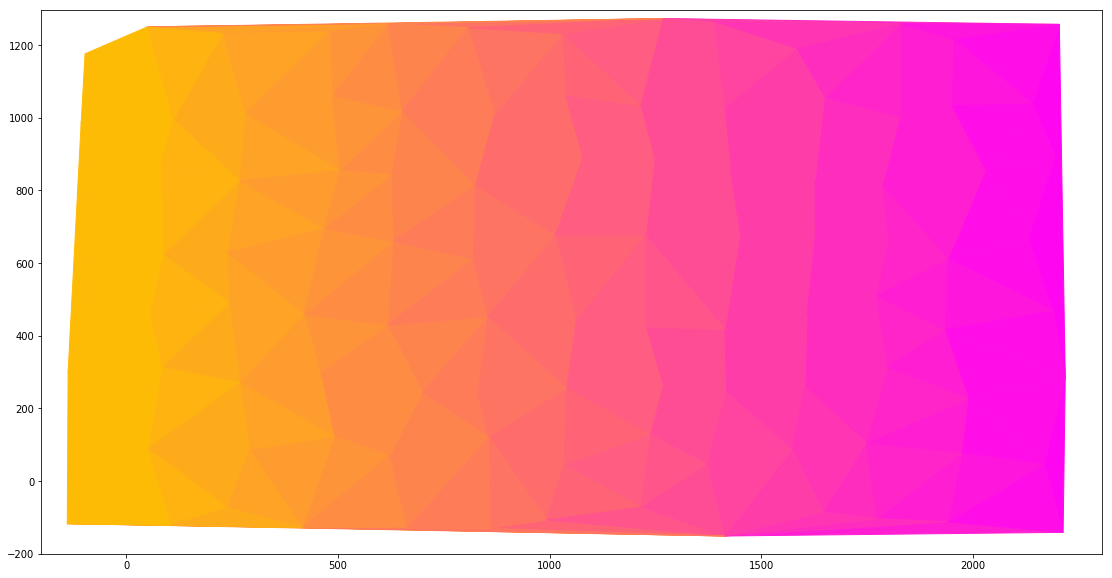

In [62]:
fig = plt.figure(figsize=(19,10))

ax = plt.gca()

for point in samplePoints[tri]:
    centers = centerTriangle(point)
    percentageX = min(normalizeCoordinate(centers[0],bleedX,graphWidth),1)
    
    currentX = int(normalizeCoordinate(centerTriangle(point)[0]*color_steps, bleedX, graphWidth))
    
    xColor, yColor = gradi_X[currentX], gradi_X[currentX+1]
    intColor = calculate_gradient(xColor, yColor, 3)[1]
    
    p = Polygon(point, closed=True, color=intColor)
    ax.add_patch(p)
        
#plt.scatter(samplePoints[:,0], samplePoints[:,1])
ax.set_xlim(-200,graphWidth*1.2)
ax.set_ylim(-200,graphHeight*1.2)

Much nicer! But we lose some of the edges since we're only differentiating color primarily in the x-axis. We can add more depth if we add a second gradient in the y direction. [We also want to take advantage of our natural adaptation assuming that light comes from above](https://www.newsweek.com/visual-perception-unconscious-biases-sight-neuroscience-brain-eye-1295461) to give the sense that this is a real wall that we're looking at with some depth.

In [63]:
color_steps = 20

first_c = Color("#febf01")
second_c = Color("#ff02f6")
third_c = Color("#444444")
fourth_c = Color("#ffffff")

bitmapPhoto = np.zeros((graphWidth,graphHeight,3), 'uint8')

In [64]:
gradi_X = calculate_gradient(first_c.rgb, second_c.rgb, color_steps)
gradi_Y = calculate_gradient(third_c.rgb, fourth_c.rgb, color_steps)

In [65]:
def rgbMap(OldValue):
    """ Remaps color percentage (0-1 value) to 8 bit values

    Keyword Arguments:
    OldValue -- Integer Value to remap. Should be from 0 to 1
    """
    return remap(OldValue, 0, 1, 0, 255)

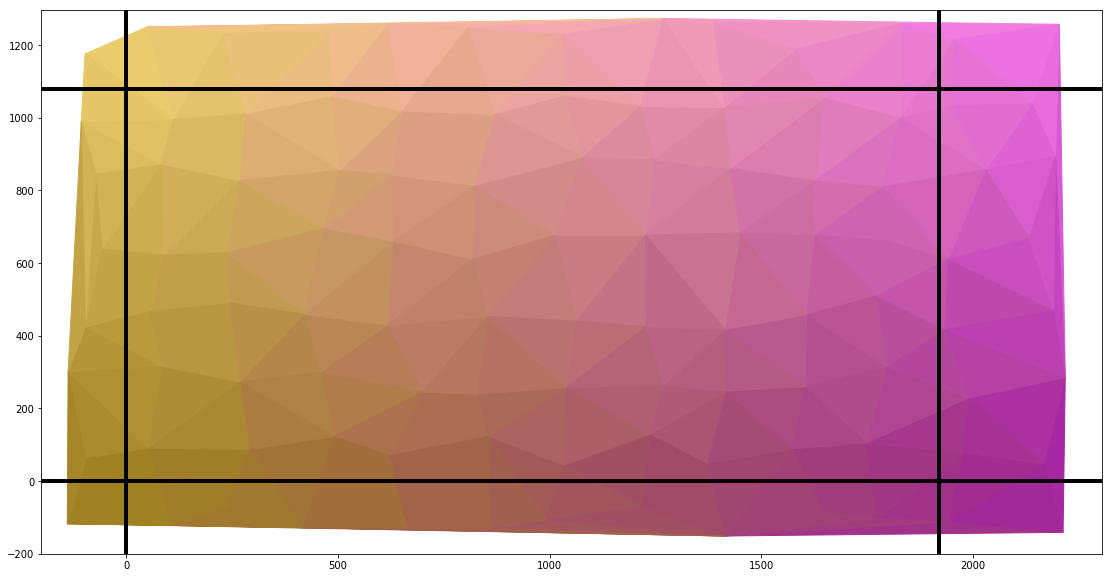

In [66]:
fig = plt.figure(figsize=(19,10))

ax = plt.gca()


for i in samplePoints[tri]:
        currentX = int(normalizeCoordinate(centerTriangle(i)[0]*color_steps, bleedX, graphWidth))
        currentY = int(normalizeCoordinate(centerTriangle(i)[1]*color_steps, bleedY, graphHeight))
        xColor, yColor = gradi_X[currentX], gradi_Y[currentY]
        intColor = calculate_gradient(xColor, yColor, 3)[1]
        colorChoice = tuple(rgbMap(intC) for intC in intColor)
        c = i[:, 0]
        r = i[:, 1]
        rr, cc = polygon(r, c)
        rr = np.clip(rr, 0, graphHeight-1)
        cc = np.clip(cc, 0, graphWidth-1)
        bitmapPhoto[cc, rr] = colorChoice
        
        p = Polygon(i, closed=True, color=intColor + (1,))
        ax.add_patch(p)
        
ax.set_xlim(-200,graphWidth*1.2)
ax.set_ylim(-200,graphHeight*1.2)

plt.axhline(y=0, color="black", linewidth=4)
plt.axvline(x=0, color="black", linewidth=4)
plt.axhline(y=graphHeight, color="black", linewidth=4)
plt.axvline(x=graphWidth, color="black", linewidth=4)

By making it lighter at the top and darker at the bottom, we get that concave look that certain points are jutting outwards toward us or inwards away from us, while still giving us that nice gradient we wanted.